In [80]:
import os
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from alibi_detect.cd import MMDDrift
import random

sys.path.append("..")

from utils.utils import *
from baseline_models.temporal.pytorch.optimizer import Optimizer
from baseline_models.temporal.pytorch.utils import *

In [81]:
hospital = ["SBK", "UHNTG", "THPC", "THPM", "UHNTW", "SMH","MSH"]
dataset="all"
BASE_DATA_PATH = "/mnt/nfs/project/delirium/drift_exp/risk_of_mortality"

In [82]:
(x_train, y_train), (x_val, y_val), (x_test, y_test), feats, orig_dims, admin_data = import_dataset_hospital(BASE_DATA_PATH, dataset, hospital, shuffle=True)

2022-06-27 16:22:40,418 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/risk_of_mortality/aggregated_events.parquet


Load data from aggregated events...


2022-06-27 16:22:40,839 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/risk_of_mortality/aggmeta_start_ts.parquet
2022-06-27 16:22:40,949 INFO cyclops.feature_handler - Loading features from file...
2022-06-27 16:22:40,953 INFO cyclops.feature_handler - Found file to load for static features...
2022-06-27 16:22:40,954 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-06-27 16:22:40,983 INFO cyclops.feature_handler - Found file to load for temporal features...


Load data from feature handler...


2022-06-27 16:22:45,864 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Load data from admin data...


2022-06-27 16:22:54,426 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/risk_of_mortality/aggmeta_end_ts.parquet


In [83]:
feature_handler = FeatureHandler()
feature_handler.load(BASE_DATA_PATH, "features")

# Get types of columns
numerical_cols = feature_handler.get_numerical_feature_names()["temporal"]
    
x_train_normalized = x_train.copy()
x_val_normalized = x_val.copy()
x_test_normalized = x_test.copy()

for col in numerical_cols:
    scaler = StandardScaler().fit(x_train[col].values.reshape(-1, 1))
    x_train_normalized[col] = pd.Series(
        np.squeeze(scaler.transform(x_train[col].values.reshape(-1, 1))),
        index=x_train[col].index,
    )
    x_val_normalized[col] = pd.Series(
        np.squeeze(scaler.transform(x_val[col].values.reshape(-1, 1))),
        index=x_val[col].index,
    )
    x_test_normalized[col] = pd.Series(
        np.squeeze(scaler.transform(x_test[col].values.reshape(-1, 1))),
        index=x_test[col].index,
    )

OUT_DATA_PATH = "/mnt/nfs/project/delirium/drift_exp/datasets"
os.makedirs(os.path.join(OUT_DATA_PATH, dataset), exist_ok=True)

x_train_normalized.to_parquet(
    os.path.join(OUT_DATA_PATH, dataset, "x_train.parquet")
)
x_val_normalized.to_parquet(os.path.join(OUT_DATA_PATH, dataset, "x_val.parquet"))
x_test_normalized.to_parquet(os.path.join(OUT_DATA_PATH, dataset, "x_test.parquet"))

np.save(os.path.join(OUT_DATA_PATH, dataset, "y_train.npy"), y_train)
np.save(os.path.join(OUT_DATA_PATH, dataset, "y_val.npy"), y_val)
np.save(os.path.join(OUT_DATA_PATH, dataset, "y_test.npy"), y_test)

2022-06-27 16:23:15,072 INFO cyclops.feature_handler - Loading features from file...
2022-06-27 16:23:15,073 INFO cyclops.feature_handler - Found file to load for static features...
2022-06-27 16:23:15,074 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-06-27 16:23:15,104 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-06-27 16:23:19,974 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


## Create Data Streams

In [84]:
from datetime import date, timedelta

#####################################################
## a given date contains data from previous two weeks 
#####################################################

start_date = date(2018, 1, 1)
end_date = date(2020, 8, 1)

def daterange(start_date, end_date, stride, window):
    for n in range(int((end_date - start_date).days)):
        if start_date + timedelta(n*stride+window) < end_date:
            yield start_date+ timedelta(n*stride)
            

def get_streams(x, y, admin_data, start_date, end_date, stride, window):
    target_stream_x = []
    target_stream_y = [] 
    measure_dates = []

    admit_df = admin_data[[ENCOUNTER_ID,ADMIT_TIMESTAMP]].sort_values(by=ADMIT_TIMESTAMP)
    for single_date in daterange(start_date, end_date, stride, window):
        if single_date.day == 1:
            print(single_date.strftime("%Y-%m-%d"),"-",(single_date+timedelta(days=window)).strftime("%Y-%m-%d"))
        encounters_inwindow = admit_df.loc[((single_date+timedelta(days=window)).strftime("%Y-%m-%d") > admit_df[ADMIT_TIMESTAMP].dt.strftime("%Y-%m-%d")) 
                           & (admit_df[ADMIT_TIMESTAMP].dt.strftime("%Y-%m-%d") >= single_date.strftime("%Y-%m-%d")), ENCOUNTER_ID].unique()
        encounter_ids = x.index.get_level_values(0).unique()
        x_inwindow = x.loc[x.index.get_level_values(0).isin(encounters_inwindow)]
        y_inwindow = y[np.in1d(encounter_ids, encounters_inwindow)]
        if not x_inwindow.empty:
            target_stream_x.append(x_inwindow)
            target_stream_y.append(y_inwindow)
            measure_dates.append((single_date+timedelta(days=window)).strftime("%Y-%m-%d"))
    return(target_stream_x, target_stream_y, measure_dates)

x_test_stream, y_test_stream, measure_dates_test = get_streams(x_test_normalized, y_test, admin_data, start_date, end_date, stride=1, window=14)

2018-01-01 - 2018-01-15
2018-02-01 - 2018-02-15
2018-03-01 - 2018-03-15
2018-04-01 - 2018-04-15
2018-05-01 - 2018-05-15
2018-06-01 - 2018-06-15
2018-07-01 - 2018-07-15
2018-08-01 - 2018-08-15
2018-09-01 - 2018-09-15
2018-10-01 - 2018-10-15
2018-11-01 - 2018-11-15
2018-12-01 - 2018-12-15
2019-01-01 - 2019-01-15
2019-02-01 - 2019-02-15
2019-03-01 - 2019-03-15
2019-04-01 - 2019-04-15
2019-05-01 - 2019-05-15
2019-06-01 - 2019-06-15
2019-07-01 - 2019-07-15
2019-08-01 - 2019-08-15
2019-09-01 - 2019-09-15
2019-10-01 - 2019-10-15
2019-11-01 - 2019-11-15
2019-12-01 - 2019-12-15
2020-01-01 - 2020-01-15
2020-02-01 - 2020-02-15
2020-03-01 - 2020-03-15
2020-04-01 - 2020-04-15
2020-05-01 - 2020-05-15
2020-06-01 - 2020-06-15
2020-07-01 - 2020-07-15


## Rolling Window (14 days)

In [85]:
# compare data for patients admitted in the same date ACROSS TIMESTEPS (e.g. all patients have same admit date) --> patient deteroriation
# compare data for patients ACROSS DATE (timestep agnostic) --> more of dataset shift 
# compare data for group of patients ACROSS DATE and TIMESTEP --> dataset shift + deterioration
threshold = 0.05
num_timesteps = 6
stride=1
window=14
random.seed(1)

#####################################################
## rolling window - not cumulatively including data and no adjustment made when drift occurs
##################################################### 
def rolling_window(stride, window, num_timesteps, series, threshold):

    p_vals = np.asarray([])
    dist_vals = np.asarray([])
    i = 0 
    while i+stride+window < len(series):
        feat_index = 0
        
        prev = pd.concat(series[i:i+stride])
        prev = prev[~prev.index.duplicated(keep='first')]
        prev = reshape_inputs(prev, num_timesteps)
        #prev = prev.reshape(prev.shape[0]*prev.shape[1],prev.shape[2])
        next = pd.concat(series[i+window:i+window+stride])
        next = next[~next.index.duplicated(keep='first')]
        next = reshape_inputs(next, num_timesteps)
        #next = next.reshape(next.shape[0]*next.shape[1],next.shape[2])
        if next.shape[0]<=2 or prev.shape[0]<=2:
            break
            
        ## run distribution shift check here
        cd = MMDDrift(prev, backend='pytorch', p_val=.05)
        preds = cd.predict(next, return_p_val=True, return_distance=True)
        p_val = preds['data']['p_val']
        if p_val < threshold:
            print("P-value below threshold.")
            print(i,"-", i+stride,"-->",i+window,"-",i+stride+window,"\tP-Value: ",p_val)
        dist_val = preds['data']['distance']
        dist_vals = np.concatenate((dist_vals, np.repeat(dist_val, 1)))
        p_vals = np.concatenate((p_vals, np.repeat(p_val, 1)))
        i += 1
            
    return dist_vals, p_vals

dist_vals_test, p_vals_test = rolling_window(stride, window, num_timesteps, x_test_stream, threshold)

P-value below threshold.
6 - 7 --> 20 - 21 	P-Value:  0.029999999329447746
P-value below threshold.
9 - 10 --> 23 - 24 	P-Value:  0.029999999329447746
P-value below threshold.
10 - 11 --> 24 - 25 	P-Value:  0.019999999552965164
P-value below threshold.
11 - 12 --> 25 - 26 	P-Value:  0.029999999329447746
P-value below threshold.
60 - 61 --> 74 - 75 	P-Value:  0.019999999552965164
P-value below threshold.
104 - 105 --> 118 - 119 	P-Value:  0.019999999552965164
P-value below threshold.
160 - 161 --> 174 - 175 	P-Value:  0.019999999552965164
P-value below threshold.
161 - 162 --> 175 - 176 	P-Value:  0.03999999910593033
P-value below threshold.
165 - 166 --> 179 - 180 	P-Value:  0.0
P-value below threshold.
166 - 167 --> 180 - 181 	P-Value:  0.009999999776482582
P-value below threshold.
167 - 168 --> 181 - 182 	P-Value:  0.0
P-value below threshold.
168 - 169 --> 182 - 183 	P-Value:  0.009999999776482582
P-value below threshold.
403 - 404 --> 417 - 418 	P-Value:  0.029999999329447746
P-val

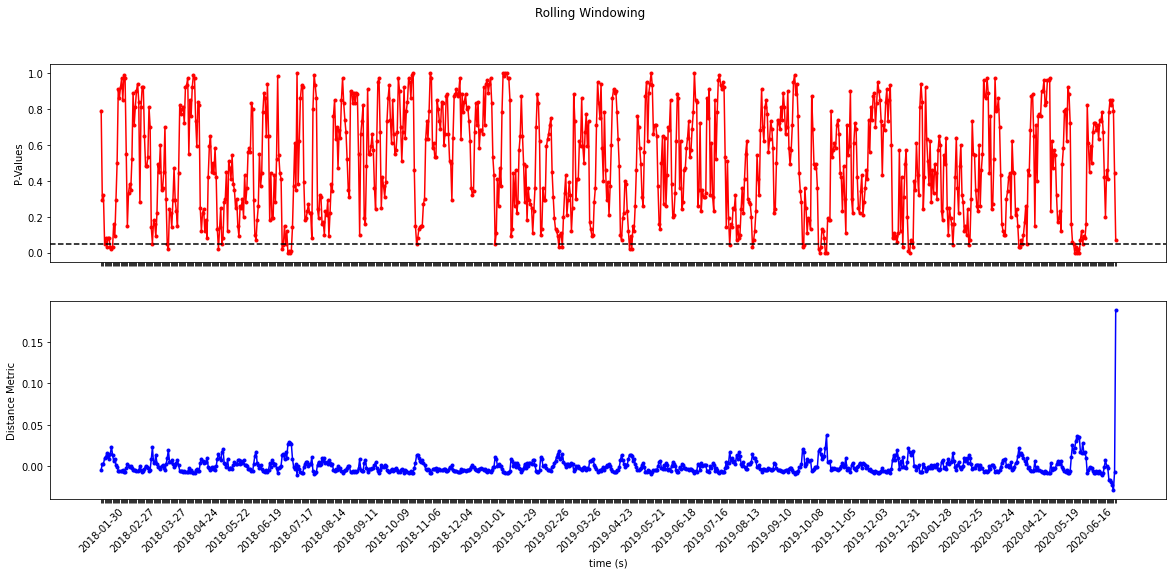

In [86]:
measure_dates_test_14d = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=window)).strftime("%Y-%m-%d") for date in measure_dates_test]
results = percentile_list = pd.DataFrame(
    {'dates': measure_dates_test_14d[1:len(p_vals_test)],
     'p_val_val': p_vals_test[1:len(p_vals_test)],
     'dist metric_val': dist_vals_test[1:len(p_vals_test)],
    })

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
fig.suptitle('Rolling Windowing')

ax1.plot(measure_dates_test_14d[1:len(p_vals_test)], p_vals_test[1:len(p_vals_test)], '.-', color="red")
ax1.axhline(y=0.05, color='black', linestyle='--')
ax1.set_ylabel('P-Values')
ax1.set_xticklabels([])
        
ax2.plot(measure_dates_test_14d[1:len(p_vals_test)], dist_vals_test[1:len(p_vals_test)], '.-',color="blue")
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Distance Metric')
ax2.tick_params(axis='x', labelrotation=45)
for index, label in enumerate(ax2.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()

## Cumulating Rolling Window (14 days)

In [87]:
threshold = 0.05
random.seed(1)
#####################################################
## dynamically adjusting drift detector - if drift is significant, reference dataset is reset to current time 
#####################################################
def cumulative_rolling_window(stride, window, num_timesteps, series, threshold):

    p_vals = np.asarray([])
    dist_vals = np.asarray([])
    run_length = int(window)
    i = 1
    
    while i+stride+window <= len(series):
        feat_index = 0
        
        prev = pd.concat(series[max(int(i)-run_length,0):int(i)])
        prev = prev[~prev.index.duplicated(keep='first')]
        prev = reshape_inputs(prev, num_timesteps)
        #prev = prev.reshape(prev.shape[0]*prev.shape[1],prev.shape[2])
        next = pd.concat(series[max(int(i)+window,0):int(i)+stride+window])
        next = next[~next.index.duplicated(keep='first')]
        next = reshape_inputs(next, num_timesteps)
        #next = next.reshape(next.shape[0]*next.shape[1],next.shape[2])
        if next.shape[0]<=2 or prev.shape[0]<=2:
            break
            
        ## run distribution shift check here
        cd = MMDDrift(prev, backend='pytorch', p_val=.05)
        preds = cd.predict(next, return_p_val=True, return_distance=True)
        p_val = preds['data']['p_val']
        dist_val = preds['data']['distance']

        #print(max(int(i)-run_length,0),"-", int(i),"-->",max(int(i)+window,0),"-",int(i)+stride+window,"\tP-Value: ",p_val)
        
        #####################################
        if p_val >= threshold:
            dist_vals = np.concatenate((dist_vals, np.repeat(dist_val, 1)))
            dist_vals = np.concatenate((dist_vals, np.repeat(0, stride-1)))
            p_vals = np.concatenate((p_vals, np.repeat(p_val, 1)))
            p_vals = np.concatenate((p_vals, np.repeat(0, stride-1)))
        else:
            print("P-value below threshold, reset.")
            print(max(int(i)-run_length,0),"-", int(i),"-->",max(int(i)+window,0),"-",int(i)+stride+window,"\tP-Value: ",p_val)
            dist_vals = np.concatenate((dist_vals, np.repeat(dist_val, 1)))
            p_vals = np.concatenate((p_vals, np.repeat(p_val, 1)))
        i += stride
        run_length += stride

    return dist_vals, p_vals

dist_vals_test, p_vals_test = cumulative_rolling_window(stride, window, num_timesteps, x_test_stream, threshold)

P-value below threshold, reset.
0 - 45 --> 59 - 60 	P-Value:  0.03999999910593033
P-value below threshold, reset.
0 - 46 --> 60 - 61 	P-Value:  0.029999999329447746
P-value below threshold, reset.
0 - 137 --> 151 - 152 	P-Value:  0.019999999552965164
P-value below threshold, reset.
0 - 159 --> 173 - 174 	P-Value:  0.029999999329447746
P-value below threshold, reset.
0 - 160 --> 174 - 175 	P-Value:  0.019999999552965164
P-value below threshold, reset.
0 - 161 --> 175 - 176 	P-Value:  0.009999999776482582
P-value below threshold, reset.
0 - 162 --> 176 - 177 	P-Value:  0.009999999776482582
P-value below threshold, reset.
0 - 163 --> 177 - 178 	P-Value:  0.019999999552965164
P-value below threshold, reset.
0 - 164 --> 178 - 179 	P-Value:  0.029999999329447746
P-value below threshold, reset.
0 - 165 --> 179 - 180 	P-Value:  0.0
P-value below threshold, reset.
0 - 166 --> 180 - 181 	P-Value:  0.0
P-value below threshold, reset.
0 - 167 --> 181 - 182 	P-Value:  0.0
P-value below threshold, r

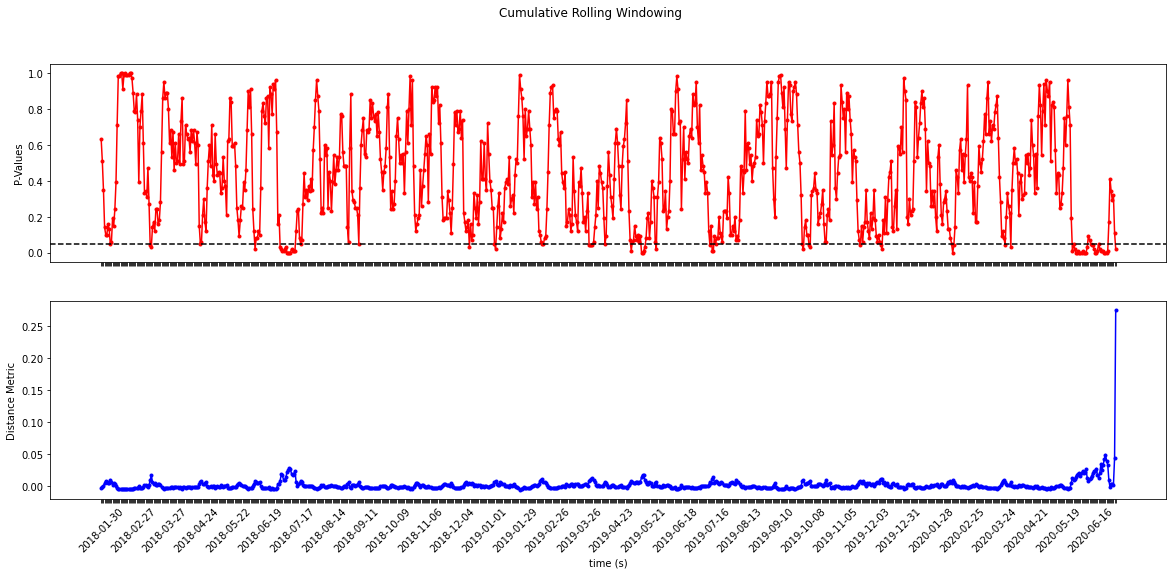

In [88]:
measure_dates_test_14d = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=window)).strftime("%Y-%m-%d") for date in measure_dates_test]
results = percentile_list = pd.DataFrame(
    {'dates': measure_dates_test_14d[1:len(p_vals_test)],
     'p_val_val': p_vals_test[1:len(p_vals_test)],
     'dist metric_val': dist_vals_test[1:len(p_vals_test)],
    })

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
fig.suptitle('Cumulative Rolling Windowing')

ax1.plot(measure_dates_test_14d[1:len(p_vals_test)], p_vals_test[1:len(p_vals_test)], '.-', color="red")
ax1.axhline(y=0.05, color='black', linestyle='--')
ax1.set_ylabel('P-Values')
ax1.set_xticklabels([])
        
ax2.plot(measure_dates_test_14d[1:len(p_vals_test)], dist_vals_test[1:len(p_vals_test)], '.-',color="blue")
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Distance Metric')
ax2.tick_params(axis='x', labelrotation=45)
for index, label in enumerate(ax2.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()

## Dynamic Rolling Window (14 days)

In [89]:
threshold = 0.05
random.seed(1)
#####################################################
## dynamically adjusting drift detector - if drift is significant, reference dataset is reset to current time 
#####################################################
def dynamic_rolling_window(stride, window, num_timesteps, series, threshold):

    p_vals = np.asarray([])
    dist_vals = np.asarray([])
    run_length = int(window)
    i = 1
    
    while i+stride+window <= len(series):
        feat_index = 0
        
        prev = pd.concat(series[max(int(i)-run_length,0):int(i)])
        prev = prev[~prev.index.duplicated(keep='first')]
        prev = reshape_inputs(prev, num_timesteps)
        #prev = prev.reshape(prev.shape[0]*prev.shape[1],prev.shape[2])
        next = pd.concat(series[max(int(i)+window,0):int(i)+stride+window])
        next = next[~next.index.duplicated(keep='first')]
        next = reshape_inputs(next, num_timesteps)
        #next = next.reshape(next.shape[0]*next.shape[1],next.shape[2])
        if next.shape[0]<=2 or prev.shape[0]<=2:
            break
            
        ## run distribution shift check here
        cd = MMDDrift(prev, backend='pytorch', p_val=.05)
        preds = cd.predict(next, return_p_val=True, return_distance=True)
        p_val = preds['data']['p_val']
        dist_val = preds['data']['distance']

        #print(max(int(i)-run_length,0),"-", int(i),"-->",max(int(i)+window,0),"-",int(i)+stride+window,"\tP-Value: ",p_val)
        
        #####################################
        if p_val >= threshold:
            dist_vals = np.concatenate((dist_vals, np.repeat(dist_val, 1)))
            dist_vals = np.concatenate((dist_vals, np.repeat(0, stride-1)))
            p_vals = np.concatenate((p_vals, np.repeat(p_val, 1)))
            p_vals = np.concatenate((p_vals, np.repeat(0, stride-1)))
            i += stride
            run_length += stride
        else:
            print("P-value below threshold, reset.")
            print(max(int(i)-run_length,0),"-", int(i),"-->",max(int(i)+window,0),"-",int(i)+stride+window,"\tP-Value: ",p_val)
            dist_vals = np.concatenate((dist_vals, np.repeat(dist_val, 1)))
            p_vals = np.concatenate((p_vals, np.repeat(p_val, 1)))
            i+=1
            run_length = stride

    return dist_vals, p_vals

dist_vals_test, p_vals_test = dynamic_rolling_window(stride, window, num_timesteps, x_test_stream, threshold)

P-value below threshold, reset.
0 - 45 --> 59 - 60 	P-Value:  0.019999999552965164
P-value below threshold, reset.
45 - 46 --> 60 - 61 	P-Value:  0.029999999329447746
P-value below threshold, reset.
46 - 159 --> 173 - 174 	P-Value:  0.03999999910593033
P-value below threshold, reset.
159 - 165 --> 179 - 180 	P-Value:  0.03999999910593033
P-value below threshold, reset.
165 - 166 --> 180 - 181 	P-Value:  0.009999999776482582
P-value below threshold, reset.
166 - 167 --> 181 - 182 	P-Value:  0.009999999776482582
P-value below threshold, reset.
167 - 168 --> 182 - 183 	P-Value:  0.019999999552965164
P-value below threshold, reset.
168 - 169 --> 183 - 184 	P-Value:  0.019999999552965164
P-value below threshold, reset.
169 - 195 --> 209 - 210 	P-Value:  0.029999999329447746
P-value below threshold, reset.
195 - 388 --> 402 - 403 	P-Value:  0.03999999910593033
P-value below threshold, reset.
388 - 420 --> 434 - 435 	P-Value:  0.029999999329447746
P-value below threshold, reset.
420 - 433 -->

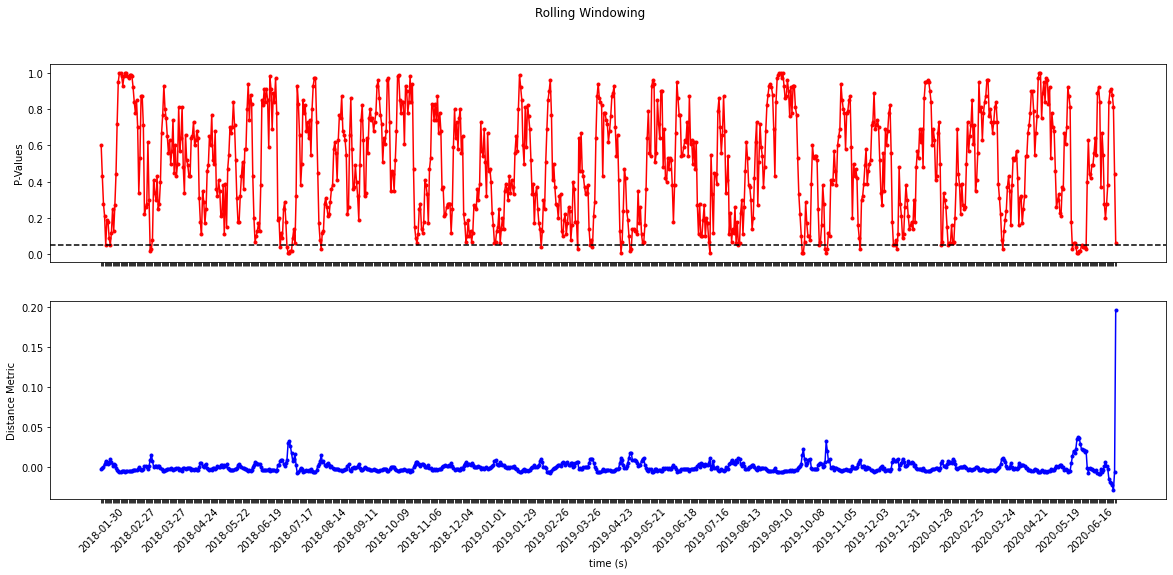

In [90]:
measure_dates_test_14d = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=window)).strftime("%Y-%m-%d") for date in measure_dates_test]
results = percentile_list = pd.DataFrame(
    {'dates': measure_dates_test_14d[1:len(p_vals_test)],
     'p_val_val': p_vals_test[1:len(p_vals_test)],
     'dist metric_val': dist_vals_test[1:len(p_vals_test)],
    })

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
fig.suptitle('Rolling Windowing')

ax1.plot(measure_dates_test_14d[1:len(p_vals_test)], p_vals_test[1:len(p_vals_test)], '.-', color="red")
ax1.axhline(y=0.05, color='black', linestyle='--')
ax1.set_ylabel('P-Values')
ax1.set_xticklabels([])
        
ax2.plot(measure_dates_test_14d[1:len(p_vals_test)], dist_vals_test[1:len(p_vals_test)], '.-',color="blue")
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Distance Metric')
ax2.tick_params(axis='x', labelrotation=45)
for index, label in enumerate(ax2.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()

## Rolling Window (60 Days)

P-value below threshold.
6 - 7 --> 66 - 67 	P-Value:  0.03999999910593033
P-value below threshold.
7 - 8 --> 67 - 68 	P-Value:  0.03999999910593033
P-value below threshold.
59 - 60 --> 119 - 120 	P-Value:  0.029999999329447746
P-value below threshold.
60 - 61 --> 120 - 121 	P-Value:  0.009999999776482582
P-value below threshold.
61 - 62 --> 121 - 122 	P-Value:  0.03999999910593033
P-value below threshold.
91 - 92 --> 151 - 152 	P-Value:  0.029999999329447746
P-value below threshold.
115 - 116 --> 175 - 176 	P-Value:  0.03999999910593033
P-value below threshold.
117 - 118 --> 177 - 178 	P-Value:  0.03999999910593033
P-value below threshold.
118 - 119 --> 178 - 179 	P-Value:  0.009999999776482582
P-value below threshold.
119 - 120 --> 179 - 180 	P-Value:  0.0
P-value below threshold.
120 - 121 --> 180 - 181 	P-Value:  0.0
P-value below threshold.
121 - 122 --> 181 - 182 	P-Value:  0.0
P-value below threshold.
122 - 123 --> 182 - 183 	P-Value:  0.0
P-value below threshold.
123 - 124 --> 1

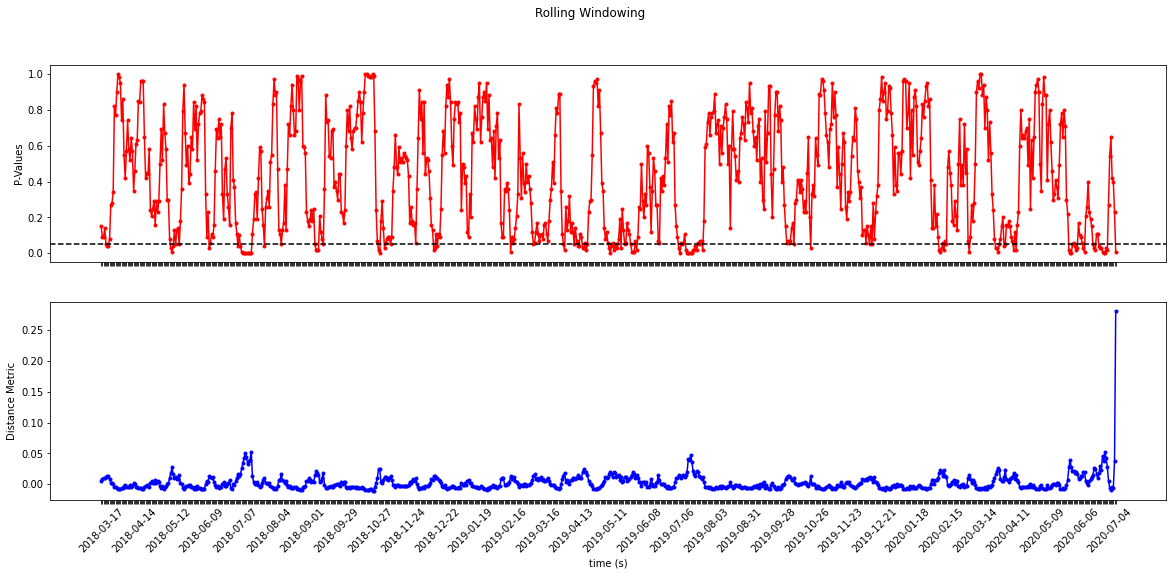

In [91]:
window=60
stride=1
dist_vals_test, p_vals_test = rolling_window(stride, window, num_timesteps, x_test_stream, threshold)

measure_dates_test_60d = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=window)).strftime("%Y-%m-%d") for date in measure_dates_test]
results = percentile_list = pd.DataFrame(
    {'dates': measure_dates_test_60d[1:len(p_vals_test)],
     'p_val_val': p_vals_test[1:len(p_vals_test)],
     'dist metric_val': dist_vals_test[1:len(p_vals_test)],
    })

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
fig.suptitle('Rolling Windowing')

ax1.plot(measure_dates_test_60d[1:len(p_vals_test)], p_vals_test[1:len(p_vals_test)], '.-', color="red")
ax1.axhline(y=0.05, color='black', linestyle='--')
ax1.set_ylabel('P-Values')
ax1.set_xticklabels([])
        
ax2.plot(measure_dates_test_60d[1:len(p_vals_test)], dist_vals_test[1:len(p_vals_test)], '.-',color="blue")
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Distance Metric')
ax2.tick_params(axis='x', labelrotation=45)
for index, label in enumerate(ax2.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()

P-value below threshold, reset.
0 - 113 --> 173 - 174 	P-Value:  0.03999999910593033
P-value below threshold, reset.
0 - 114 --> 174 - 175 	P-Value:  0.019999999552965164
P-value below threshold, reset.
0 - 115 --> 175 - 176 	P-Value:  0.009999999776482582
P-value below threshold, reset.
0 - 116 --> 176 - 177 	P-Value:  0.03999999910593033
P-value below threshold, reset.
0 - 117 --> 177 - 178 	P-Value:  0.019999999552965164
P-value below threshold, reset.
0 - 118 --> 178 - 179 	P-Value:  0.0
P-value below threshold, reset.
0 - 119 --> 179 - 180 	P-Value:  0.0
P-value below threshold, reset.
0 - 120 --> 180 - 181 	P-Value:  0.0
P-value below threshold, reset.
0 - 121 --> 181 - 182 	P-Value:  0.0
P-value below threshold, reset.
0 - 122 --> 182 - 183 	P-Value:  0.0
P-value below threshold, reset.
0 - 123 --> 183 - 184 	P-Value:  0.0
P-value below threshold, reset.
0 - 124 --> 184 - 185 	P-Value:  0.0
P-value below threshold, reset.
0 - 125 --> 185 - 186 	P-Value:  0.0
P-value below thresh

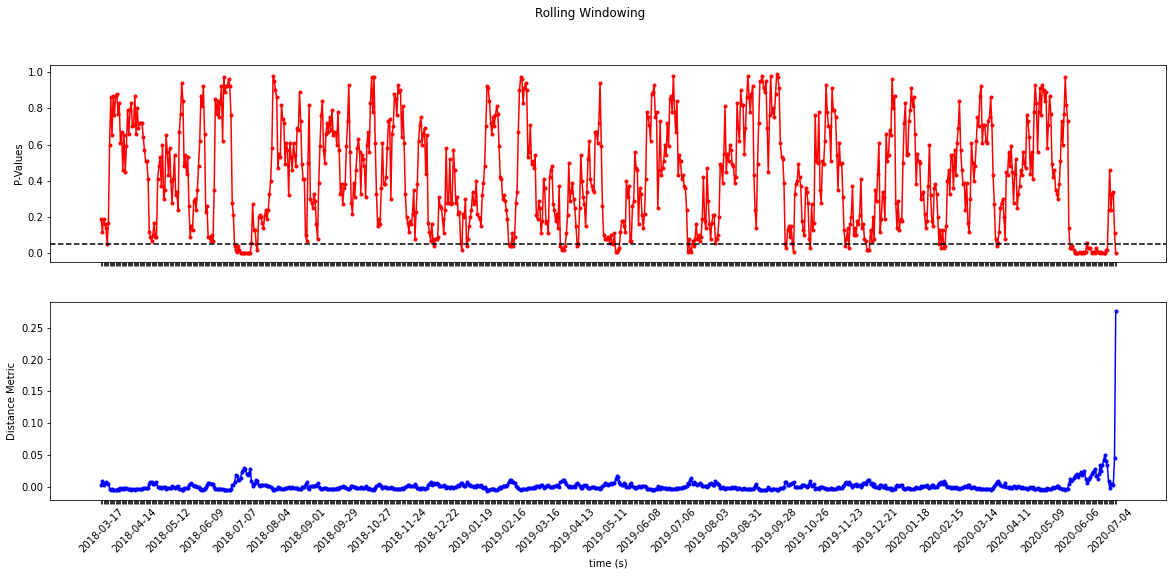

In [92]:
window=60
stride=1
dist_vals_test, p_vals_test = cumulative_rolling_window(stride, window, num_timesteps, x_test_stream, threshold)

measure_dates_test_60d = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=window)).strftime("%Y-%m-%d") for date in measure_dates_test]
results = percentile_list = pd.DataFrame(
    {'dates': measure_dates_test_60d[1:len(p_vals_test)],
     'p_val_val': p_vals_test[1:len(p_vals_test)],
     'dist metric_val': dist_vals_test[1:len(p_vals_test)],
    })

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
fig.suptitle('Rolling Windowing')

ax1.plot(measure_dates_test_60d[1:len(p_vals_test)], p_vals_test[1:len(p_vals_test)], '.-', color="red")
ax1.axhline(y=0.05, color='black', linestyle='--')
ax1.set_ylabel('P-Values')
ax1.set_xticklabels([])
        
ax2.plot(measure_dates_test_60d[1:len(p_vals_test)], dist_vals_test[1:len(p_vals_test)], '.-',color="blue")
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Distance Metric')
ax2.tick_params(axis='x', labelrotation=45)
for index, label in enumerate(ax2.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()

P-value below threshold, reset.
0 - 113 --> 173 - 174 	P-Value:  0.03999999910593033
P-value below threshold, reset.
113 - 118 --> 178 - 179 	P-Value:  0.019999999552965164
P-value below threshold, reset.
118 - 119 --> 179 - 180 	P-Value:  0.0
P-value below threshold, reset.
119 - 120 --> 180 - 181 	P-Value:  0.0
P-value below threshold, reset.
120 - 121 --> 181 - 182 	P-Value:  0.0
P-value below threshold, reset.
121 - 122 --> 182 - 183 	P-Value:  0.009999999776482582
P-value below threshold, reset.
122 - 123 --> 183 - 184 	P-Value:  0.0
P-value below threshold, reset.
123 - 124 --> 184 - 185 	P-Value:  0.019999999552965164
P-value below threshold, reset.
124 - 125 --> 185 - 186 	P-Value:  0.0
P-value below threshold, reset.
125 - 126 --> 186 - 187 	P-Value:  0.0
P-value below threshold, reset.
126 - 127 --> 187 - 188 	P-Value:  0.0
P-value below threshold, reset.
127 - 131 --> 191 - 192 	P-Value:  0.019999999552965164
P-value below threshold, reset.
131 - 232 --> 292 - 293 	P-Value: 

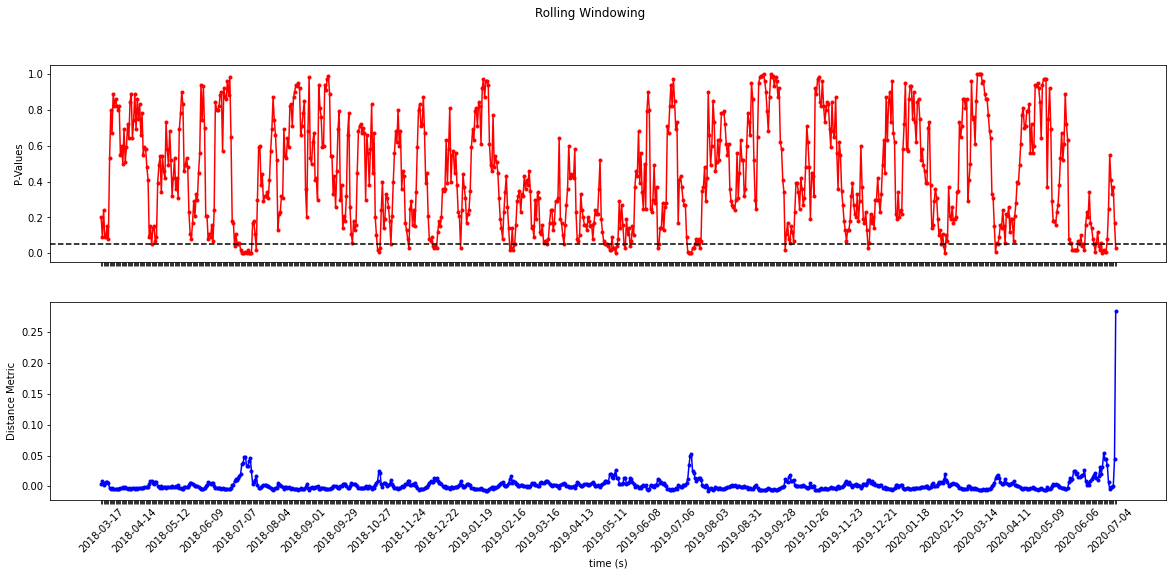

In [94]:
window=60
stride=1
dist_vals_test, p_vals_test = dynamic_rolling_window(stride, window, num_timesteps, x_test_stream, threshold)

measure_dates_test_60d = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=window)).strftime("%Y-%m-%d") for date in measure_dates_test]
results = percentile_list = pd.DataFrame(
    {'dates': measure_dates_test_60d[1:len(p_vals_test)],
     'p_val_val': p_vals_test[1:len(p_vals_test)],
     'dist metric_val': dist_vals_test[1:len(p_vals_test)],
    })

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
fig.suptitle('Rolling Windowing')

ax1.plot(measure_dates_test_60d[1:len(p_vals_test)], p_vals_test[1:len(p_vals_test)], '.-', color="red")
ax1.axhline(y=0.05, color='black', linestyle='--')
ax1.set_ylabel('P-Values')
ax1.set_xticklabels([])
        
ax2.plot(measure_dates_test_60d[1:len(p_vals_test)], dist_vals_test[1:len(p_vals_test)], '.-',color="blue")
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Distance Metric')
ax2.tick_params(axis='x', labelrotation=45)
for index, label in enumerate(ax2.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()

In [ ]:
mean_p_vals, std_p_vals, mean_dist, std_dist = run_shift_experiment(
                        outcome=OUTCOME,
                        hospital=HOSPITAL,
                        path=PATH,
                        dr_technique=DR_TECHNIQUE,
                        md_test=MD_TEST,
                        samples=SAMPLES,
                        dataset=DATASET,
                        sign_level=SIGN_LEVEL,
                        na_cutoff=NA_CUTOFF,
                        random_runs=RANDOM_RUNS,
                        calc_acc=CALC_ACC,
                        bucket_size=6, 
                        window=6
)